In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import warnings
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import shapiro

### **Loading the Data**

In [3]:
ab_df = pd.read_csv("/Users/dianisg/Desktop/codeop/GroupProject/ab_testing.csv")

# **EDA**

In [4]:
ab_df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


### **Control/experiment groups split**

In [5]:
control_df = ab_df[ab_df['Group'] == 'A'].copy().reset_index(drop=True)

In [6]:
experiment_df = ab_df[ab_df['Group'] == 'B'].copy().reset_index(drop=True)

### **Checkin for nulls/Duplicates/Unique Values**

In [58]:
control_df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,11682,A,9,342,No,Mobile,Scotland
1,19825,A,2,396,No,Desktop,Northern Ireland
2,18851,A,1,338,Yes,Desktop,Scotland
3,16702,A,5,106,No,Mobile,Northern Ireland
4,12776,A,14,351,No,Desktop,Wales


In [59]:
experiment_df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,16080,B,4,318,No,Desktop,Wales
2,13134,B,2,93,No,Desktop,Scotland
3,10041,B,9,292,No,Mobile,Northern Ireland
4,13191,B,8,434,No,Desktop,Northern Ireland


In [60]:
control_df.shape

(2519, 7)

In [61]:
experiment_df.shape

(2481, 7)

In [62]:
ab_df.Conversion.unique()

array(['No', 'Yes'], dtype=object)

In [64]:
control_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     2519 non-null   int64 
 1   Group       2519 non-null   object
 2   Page Views  2519 non-null   int64 
 3   Time Spent  2519 non-null   int64 
 4   Conversion  2519 non-null   object
 5   Device      2519 non-null   object
 6   Location    2519 non-null   object
dtypes: int64(3), object(4)
memory usage: 137.9+ KB


In [65]:
experiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     2481 non-null   int64 
 1   Group       2481 non-null   object
 2   Page Views  2481 non-null   int64 
 3   Time Spent  2481 non-null   int64 
 4   Conversion  2481 non-null   object
 5   Device      2481 non-null   object
 6   Location    2481 non-null   object
dtypes: int64(3), object(4)
memory usage: 135.8+ KB


In [66]:
ab_df['User ID'].duplicated().any()

np.False_

In [67]:
ab_df.isnull().sum()


User ID       0
Group         0
Page Views    0
Time Spent    0
Conversion    0
Device        0
Location      0
dtype: int64

In [68]:
ab_df.describe()


,User ID,Page Views,Time Spent
count,5000.000000,5000.000000,5000.000000
mean,14925.159000,7.537600,242.512600
std,2869.153773,4.022465,118.254153
min,10001.000000,1.000000,40.000000
25%,12456.250000,4.000000,137.000000
50%,14858.500000,8.000000,243.000000
75%,17379.750000,11.000000,346.000000
max,19995.000000,14.000000,449.000000


# **Visual Distributions**

### **Plotted distributions of numerical variables**

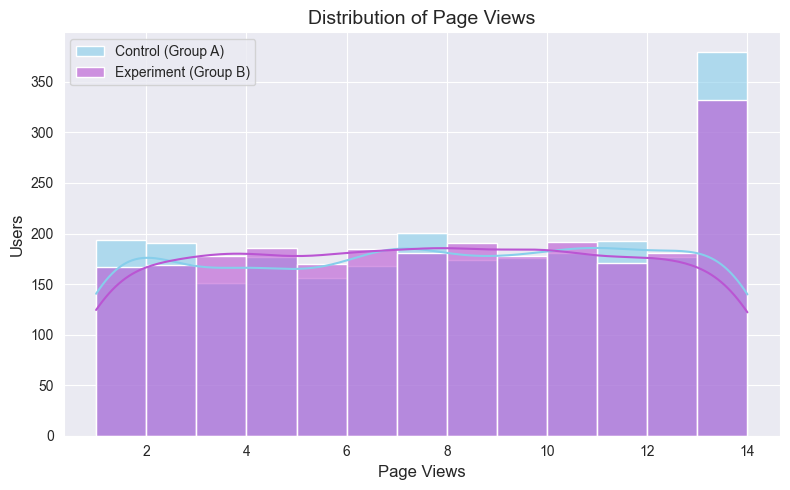

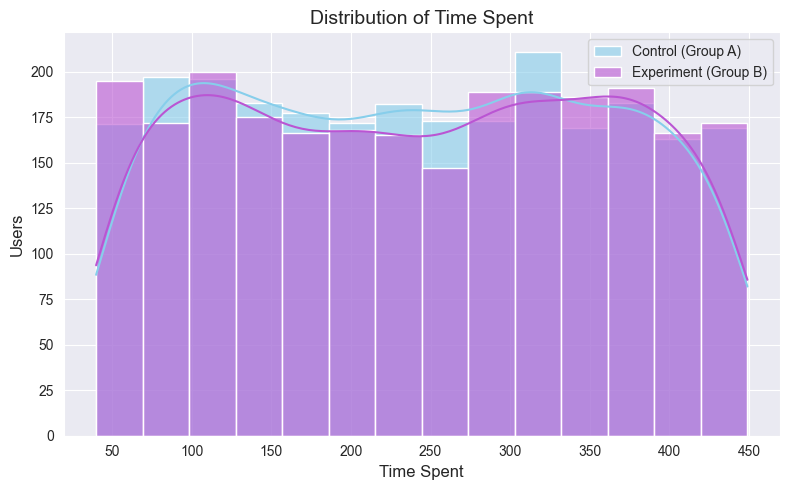

In [ ]:
for col in ['Page Views', 'Time Spent']:
    plt.figure(figsize=(8, 5))
    
    sns.histplot(control_df[col], 
                 kde=True, 
                 stat="count",       
                 label='Control (Group A)', 
                 color='skyblue', 
                 alpha=0.6)
    
    sns.histplot(experiment_df[col], 
                 kde=True, 
                 stat="count", 
                 label='Experiment (Group B)', 
                 color='mediumorchid', 
                 alpha=0.6)
    
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Users', fontsize=12)  
    plt.legend()
    plt.tight_layout()
    plt.show()


### **Plotted distribution of categorical variables**

In [10]:
converted_df = ab_df[ab_df['Conversion'] == 'Yes']

conversion_percent = (
    converted_df['Group'].value_counts(normalize=True) * 100
).reset_index()
conversion_percent.columns = ['Group', 'Percentage']
print(conversion_percent)

  Group  Percentage
0     B   71.958763
1     A   28.041237


/var/folders/g6/pd_cdn856jbf49pxtf_r988r0000gn/T/ipykernel_6023/3555549324.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conversion_percent, x='Group', y='Percentage', palette=group_colors)


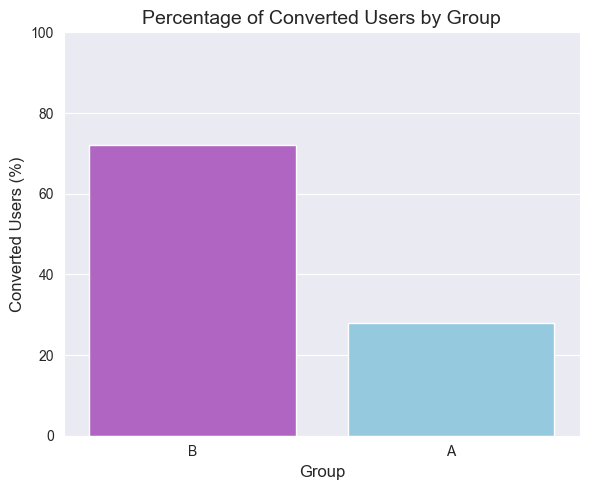

In [ ]:
converted_df = ab_df[ab_df['Conversion'] == 'Yes']

conversion_percent = (
    converted_df['Group'].value_counts(normalize=True) * 100
).reset_index()
conversion_percent.columns = ['Group', 'Percentage']

group_colors = {'A': 'skyblue', 'B': 'mediumorchid'}

plt.figure(figsize=(6, 5))
sns.barplot(data=conversion_percent, x='Group', y='Percentage', palette=group_colors)

plt.title("Percentage of Converted Users by Group", fontsize=14)
plt.xlabel("Group", fontsize=12)
plt.ylabel("Converted Users (%)", fontsize=12)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


# **A/B Testing**

### **Formulating Hypotheses**

**- Null Hypothesis (H₀):** There is no difference in user engagement between the white and black background versions of the website.

**- Alternative Hypothesis (H₁):** There is a significant difference in user engagement between the two background versions.

### **Identifying Variables**

**-Independent Variable:** Group (A or B) – the version of the website background.

**-Dependent Variables:** Page Views, Time Spent, ¿Conversion? – metrics to assess user engagement

 # **Basic Statistics:**

 calculating: mean, standard deviation and standard error (SE) for each group

In [ ]:
for col in ['Page Views', 'Time Spent']:
    print(f"\n Stats for: {col}")
    
    for group_name, group_df in [('Control', control_df), ('Experiment', experiment_df)]:
        mean = np.mean(group_df[col])
        
        std = np.std(group_df[col], ddof=1)
        
        n = len(group_df[col])
        
        se = std / np.sqrt(n)
        
        print(f"{group_name} Group:")
        print(f"  Mean            = {mean:.2f}")
        print(f"  Std Deviation   = {std:.2f}")
        print(f"  Standard Error  = {se:.4f}")



 Stats for: Page Views
Control Group:
  Mean            = 7.58
  Std Deviation   = 4.08
  Standard Error  = 0.0813
Experiment Group:
  Mean            = 7.49
  Std Deviation   = 3.96
  Standard Error  = 0.0796

 Stats for: Time Spent
Control Group:
  Mean            = 241.73
  Std Deviation   = 117.34
  Standard Error  = 2.3379
Experiment Group:
  Mean            = 243.30
  Std Deviation   = 119.19
  Standard Error  = 2.3930


In [ ]:
z = 1.96  

for col in ['Page Views', 'Time Spent']:
    print(f"\n95% Confidence Intervals for {col}")
    
    for group_name, group_df in [('Control', control_df), ('Experiment', experiment_df)]:
        mean = np.mean(group_df[col])
        std = np.std(group_df[col], ddof=1)
        n = len(group_df[col])
        se = std / np.sqrt(n)
        
        margin = z * se
        lower = mean - margin
        upper = mean + margin
        
        print(f"{group_name} Group: {mean:.2f} ± {margin:.2f} → CI = [{lower:.2f}, {upper:.2f}]")



95% Confidence Intervals for Page Views
Control Group: 7.58 ± 0.16 → CI = [7.42, 7.74]
Experiment Group: 7.49 ± 0.16 → CI = [7.34, 7.65]

95% Confidence Intervals for Time Spent
Control Group: 241.73 ± 4.58 → CI = [237.15, 246.32]
Experiment Group: 243.30 ± 4.69 → CI = [238.61, 247.99]


# **Conclusions from this:**

- The mean differences are very small, Any effect is likely not practically significant
- The confidence intervals overlap substantially, There’s no strong evidence the groups are different
- Both groups have similar standard errors, The estimates are precise, not just noisy

Based on descriptive stats and confidence intervals, we do not have evidence that the experiment (Group B) significantly changed user behavior in terms of page views or time spent. These are strong clues, but they’re not formal hypothesis tests we still need to run the statistical test to determine whether we can reject or not the null hypothesis. 

In [ ]:
from scipy.stats import ttest_ind

for col in ['Page Views', 'Time Spent']:
    stat, p = ttest_ind(control_df[col], experiment_df[col], equal_var=False)  
    print(f"\nT-Test for {col}:")
    print(f"  t-statistic = {stat:.4f}")
    print(f"  p-value     = {p:.4f}")



T-Test for Page Views:
  t-statistic = 0.7792
  p-value     = 0.4359

T-Test for Time Spent:
  t-statistic = -0.4695
  p-value     = 0.6387


# **Conclusions from this:**

- Both p-values are much higher than 0.05, so:

We fail to reject the null hypothesis
⇒ There's no statistically significant difference in page views or time spent between the control and experiment groups.